In [41]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score

pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 4]
import seaborn as sns
import plotly.express as px

In [5]:
df = pd.read_csv('HW1_var_8.csv', sep=';')
df.head()

,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,8,1000008,Форма банка (без печати работодателя),Покупка недвижимости/ строительство,1.0,0.40,женский,3,0,среднее,менеджер среднего звена,< 50,0.0,88.0,40.0,Торговля,ООО,женат / замужем,1.0,1.0,1.0,0.0,0.0,0.023529,1.0,0.0,0.0,0.0,0.500000,3.0,3.0,83.0,6.0,1.0,1.0,7.0,64.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,1000028,Поступление зарплаты на счет,Ремонт,0.0,0.39,мужской,0,0,высшее,специалист,>250,0.0,24.0,28.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1000048,Поступление зарплаты на счет,Ремонт,0.0,0.47,мужской,1,0,высшее,менеджер среднего звена,>250,1.0,230.0,39.0,Другое,ОАО,женат / замужем,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.500000,1.0,1.0,37.0,2.0,0.0,1.0,3.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,1000068,Поступление зарплаты на счет,Ремонт,1.0,0.42,мужской,0,0,Высшее/Второе высшее/Ученая степень,специалист,>250,0.0,39.0,26.0,Информационные технологии,ОАО,холост / не замужем,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.666667,2.0,1.0,43.0,3.0,1.0,1.0,8.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,1000088,2НДФЛ,Покупка недвижимости/ строительство,1.0,0.49,женский,0,0,высшее,специалист,>250,1.0,350.0,49.0,Транспорт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(10243, 44)

###Exploring data distribution and processing for subsequent segmentation

We calculate the number of unique values, empty values, zeros and their proportions for each column of df

In [7]:
def column_val(series):
    unique_count = series.nunique()
    unique_pct = series.nunique() / len(df) * 100
    zeros = (series == 0).sum() if np.issubdtype(series.dtype, np.number) else 0
    zeros_pct = zeros / len(series) * 100
    empty = series.isna().sum() + (series.astype(str).str.strip() == '').sum()
    empty_pct = empty / len(series) * 100
    return [unique_count, unique_pct, zeros, zeros_pct, empty, empty_pct]

data = []
for col in df.columns:
    data.append([col] + column_val(df[col]))

print(tabulate(data, headers=['column','unique','unique %', 'zeros','zeros %','empty','empty %'], tablefmt='orgtbl'))


| column                |   unique |     unique % |   zeros |    zeros % |   empty |     empty % |
|-----------------------+----------+--------------+---------+------------+---------+-------------|
| Номер варианта        |        1 |   0.00976276 |       0 |  0         |       0 |  0          |
| ID                    |    10243 | 100          |       0 |  0         |       0 |  0          |
| INCOME_BASE_TYPE      |        4 |   0.0390511  |       0 |  0         |      78 |  0.761496   |
| CREDIT_PURPOSE        |       10 |   0.0976276  |       0 |  0         |       0 |  0          |
| INSURANCE_FLAG        |        2 |   0.0195255  |    4079 | 39.8223    |       1 |  0.00976276 |
| DTI                   |       59 |   0.576003   |       0 |  0         |     135 |  1.31797    |
| SEX                   |        2 |   0.0195255  |       0 |  0         |       0 |  0          |
| FULL_AGE_CHILD_NUMBER |        8 |   0.0781021  |    6104 | 59.5919    |       0 |  0          |
| DEPENDAN

we study some useful statistics for each column of df the mean, median, standart deviation, min, max and data_type.

In [8]:
summary = pd.DataFrame({
    'mean' : df.describe().iloc[1],
    'median' : df.describe().iloc[5],
    'std' : df.describe().iloc[2],
    'min' : df.describe().iloc[3],
    'max' : df.describe().iloc[-1],
    'data_type' : df.dtypes.astype(str)
})
summary = summary.iloc[::-1]
summary

,mean,median,std,min,max,data_type
Номер варианта,8.000000e+00,8.000000e+00,0.000000,8.00,8.00,int64
thirty_vintage,3.028649e-02,0.000000e+00,0.171398,0.00,1.00,float64
thirty_in_a_year,1.467940e-01,0.000000e+00,0.353949,0.00,1.00,float64
sum_of_paym_months,8.169877e+01,6.300000e+01,70.024531,0.00,577.00,float64
sixty_vintage,1.582538e-02,0.000000e+00,0.124817,0.00,1.00,float64
sixty_in_a_year,8.376535e-02,0.000000e+00,0.277073,0.00,1.00,float64
own_closed,7.375171e-01,0.000000e+00,1.090537,0.00,12.00,float64
num_AccountActive90,1.757162e-01,0.000000e+00,0.470424,0.00,6.00,float64
num_AccountActive60,1.066849e-01,0.000000e+00,0.358645,0.00,4.00,float64
num_AccountActive180,4.021828e-01,0.000000e+00,0.705016,0.00,6.00,float64


We explore distribution of all 19 categorical variables in the dataset, including NaN values, to keep in account the proportion of those in our dataset, to be able to "correctly" deal with them later

In [9]:
cathegorical_val = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'SEX', 'EDUCATION', 'EMPL_TYPE',
                       'EMPL_SIZE', 'BANKACCOUNT_FLAG', 'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS',
                       'if_zalog', 'dlq_exist', 'thirty_in_a_year',	'sixty_in_a_year', 'ninety_in_a_year',
                       'thirty_vintage', 'sixty_vintage', 'ninety_vintage']
quantitative_val = df.drop(columns=cathegorical_val)
quantitative_val = quantitative_val.drop(columns=['Номер варианта', 'ID'])


for col in cathegorical_val:
    counts = df[col].value_counts(dropna=False, normalize=True)
    counts_df = counts.reset_index()
    counts_df.columns = [col, 'proportion']
    print(tabulate(counts_df, headers='keys', tablefmt='orgtbl'), '\n')

|    | INCOME_BASE_TYPE                       |   proportion |
|----+----------------------------------------+--------------|
|  0 | 2НДФЛ                                  |   0.326564   |
|  1 | Поступление зарплаты на счет           |   0.303622   |
|  2 | Форма банка (без печати работодателя)  |   0.277555   |
|  3 | Свободная форма с печатью работодателя |   0.0846432  |
|  4 | nan                                    |   0.00761496 | 

|    | CREDIT_PURPOSE                      |   proportion |
|----+-------------------------------------+--------------|
|  0 | Ремонт                              |    0.546617  |
|  1 | Покупка автомобиля                  |    0.173191  |
|  2 | Покупка недвижимости/ строительство |    0.140877  |
|  3 | Отпуск                              |    0.0354388 |
|  4 | Другое                              |    0.0294835 |
|  5 | Покупка мебели                      |    0.0218686 |
|  6 | Обучение                            |    0.0140584 |
|  7 | Покупка зе

In [10]:
len(cathegorical_val)

19

Same tables, but reperesented in bar plots

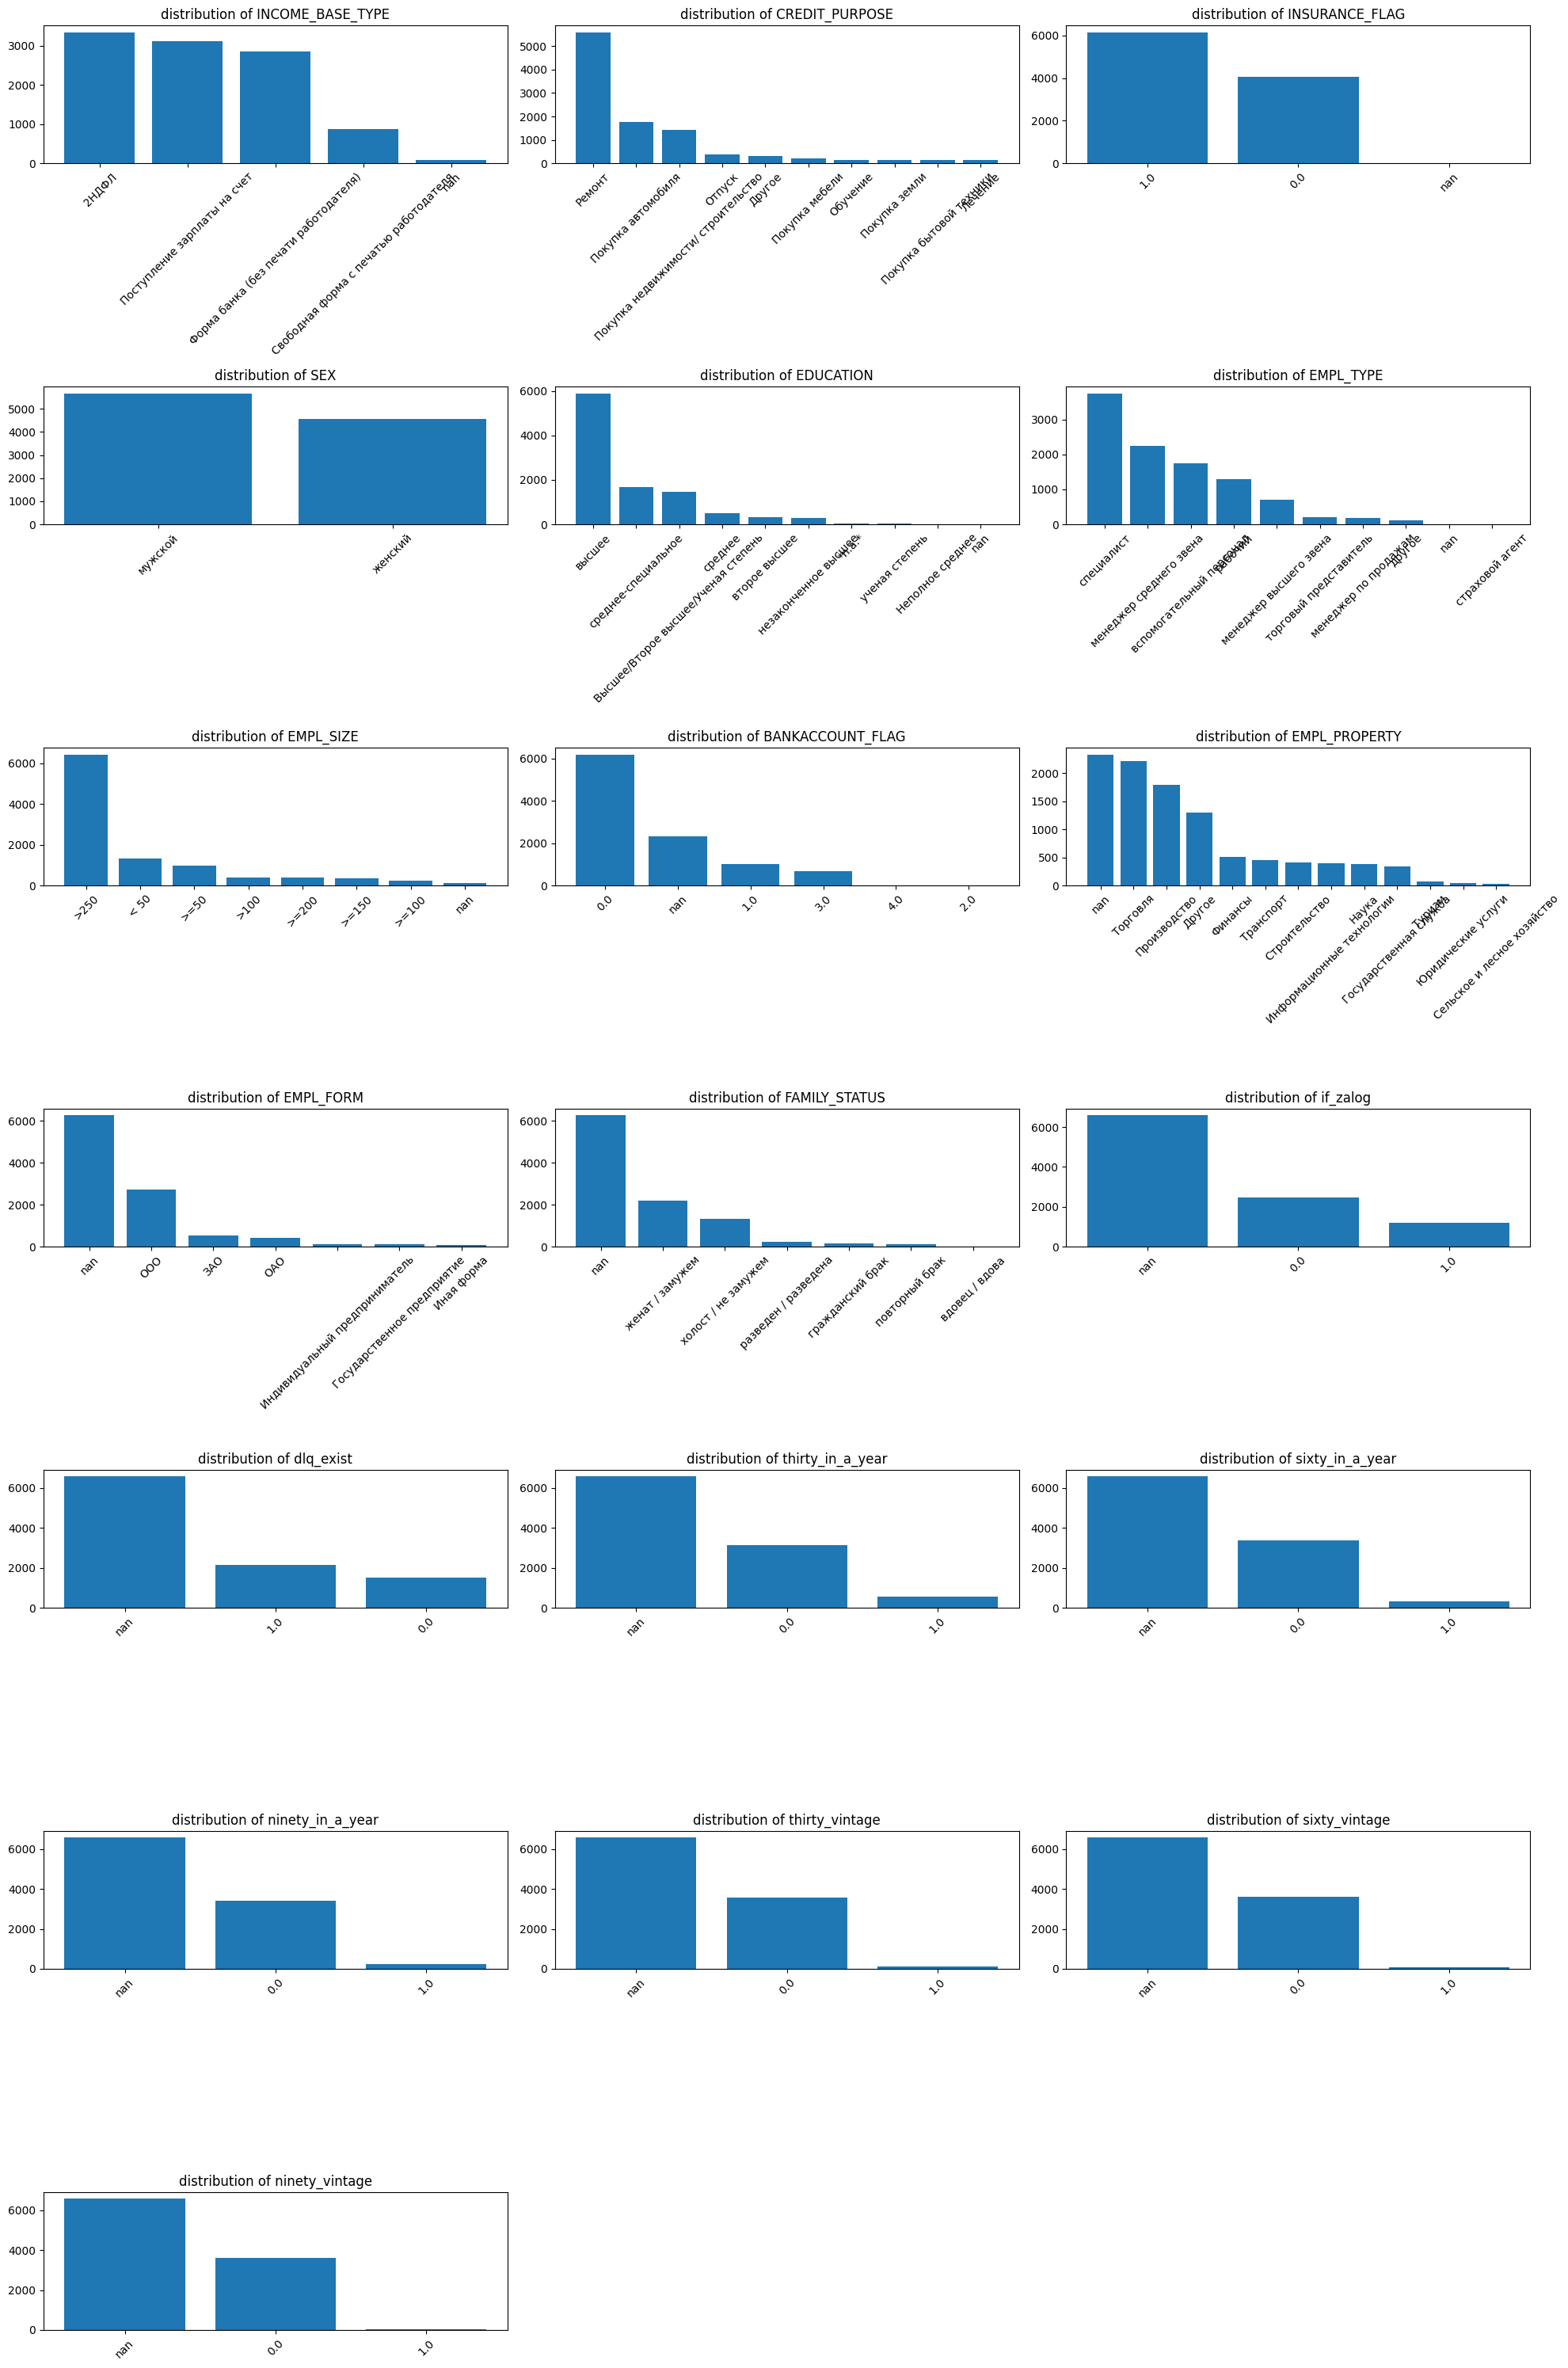

In [11]:
fig, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()
for i, col in enumerate(cathegorical_val):
    count = df[col].value_counts(dropna=False)
    axes[i].bar(count.index.astype(str), count.values)
    axes[i].set_title(f'distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(cathegorical_val), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [12]:
quantitative_val.columns

Index(['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work',
       'age', 'max90days', 'max60days', 'max30days', 'max21days', 'max14days',
       'avg_num_delay', 'num_AccountActive180', 'num_AccountActive90',
       'num_AccountActive60', 'Active_to_All_prc', 'numAccountActiveAll',
       'numAccountClosed', 'sum_of_paym_months', 'all_credits',
       'Active_not_cc', 'own_closed', 'min_MnthAfterLoan',
       'max_MnthAfterLoan'],
      dtype='object')

We now visualise the distribution of quantitative several variables using boxplots. Basically, it will give us similar information that we got in the analysis of mean, median, min, max, ... values, but now we can also find out about a serious number of outliers of several variables like: Period_at_work,  avg_num_delay, sum_of_paym_month, min_MnthAfterLoan.

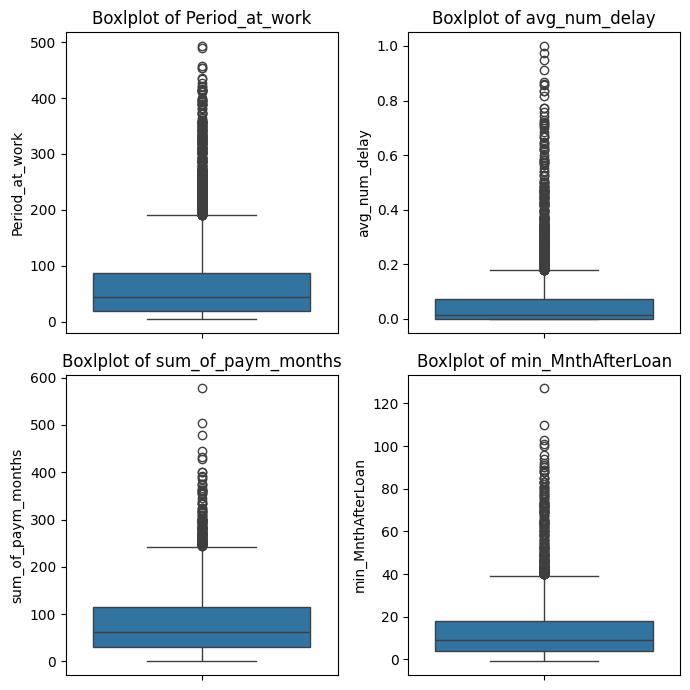

In [13]:
quantitative_outliers = ['Period_at_work', 'avg_num_delay', 'sum_of_paym_months', 'min_MnthAfterLoan']
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()

for i, col in enumerate(quantitative_outliers):
    sns.boxplot(y = df[col], ax=axes[i])
    axes[i].set_title(f'Boxlplot of {col}')

plt.tight_layout()
plt.show()

The quantitative data looks mostly uncorrelated, despite the fact that small positive correlation dominates over negative one.

However, we can notice some outliers:
* We can notice that such variables as max90days, max60days, max30days, max21days, max14days (that represent number of requests to credit bureaus in the last n days) have a relatively high correlation, this makes us able to assume that people who make at least some requests make them quite often, unlike people who don't make requests at all.

* Also, variables num_AccountActive180, num_AccountActive90, num_AccountActive60 (that represent number of active accounts accounts for the last n days)

* sum_of_paym_months and all_credits correlates with numAccountActiveAll, numAccountClosed

* max_MnthAfterLoan correlate with numAccountClosed, sum_of_paym_months, all_credits

* negative correlations: min_MnthAfterLoan with num_AccountActive180, num_AccountActive90, num_AccountActive60 and with Active_to_All_prc', 'numAccountActiveAll, numAccountClosed', 'all_credits', 'Active_not_cc'

* negative correlation: numAccountClosed with Active_to_All_prc

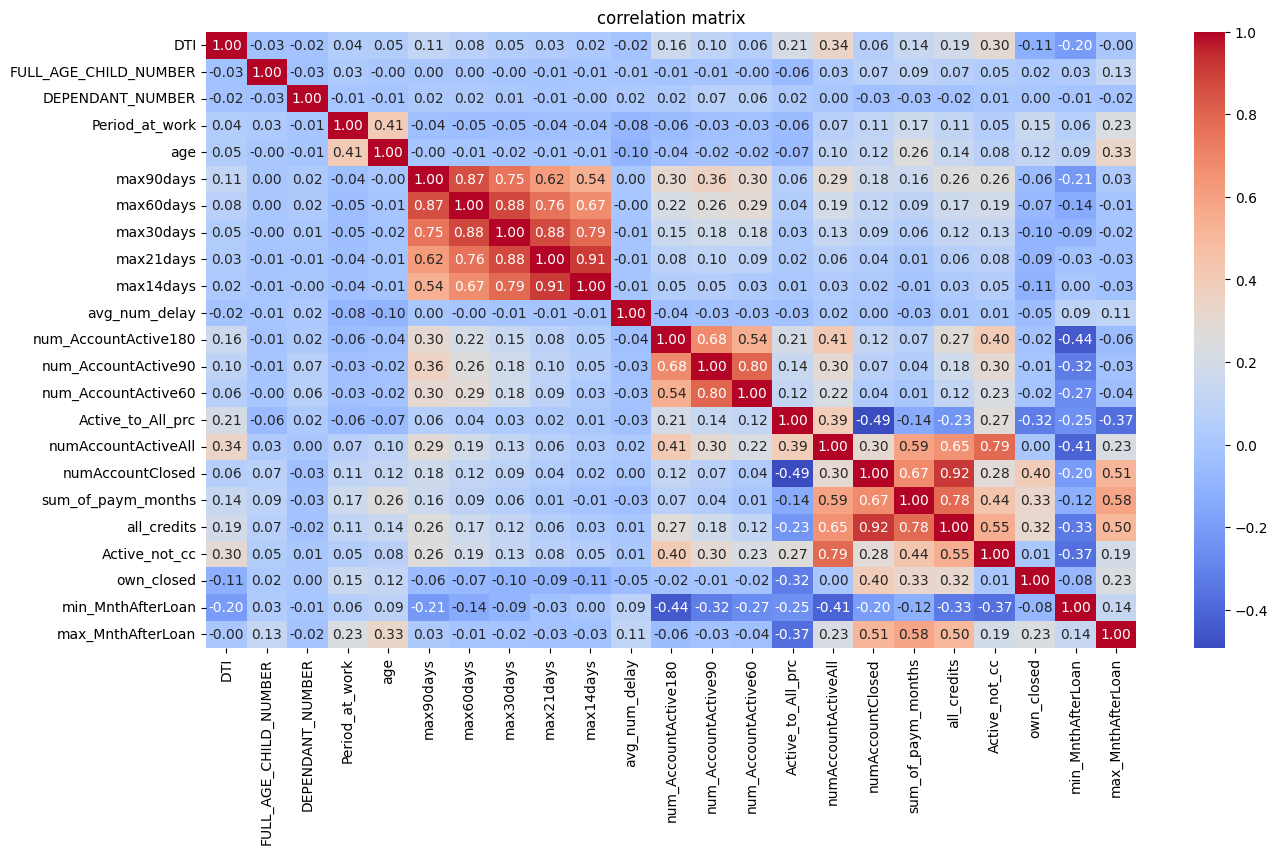

In [14]:
plt.figure(figsize=(15, 8))
sns.heatmap(quantitative_val.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('correlation matrix')
plt.show()

### check for completeness, missing and null values, incorrect characters

We want to deal with incorrect input and merge strangely created values:

In [15]:
weird_values = df[df['EDUCATION'] == '*n.a.*']
weird_values['EDUCATION'].head()

,EDUCATION
258,*n.a.*
336,*n.a.*
438,*n.a.*
468,*n.a.*
481,*n.a.*


In [16]:
df['EDUCATION'] = df['EDUCATION'].replace('*n.a.*', np.nan)

In [17]:
df['EMPL_SIZE'] = df['EMPL_SIZE'].replace({'>100' : '>=100'})
df['EMPL_SIZE'].value_counts()

,count
EMPL_SIZE,
>250,6437
< 50,1341
>=50,966
>=100,633
>=200,382
>=150,350


In [18]:
df['BANKACCOUNT_FLAG'] = df['BANKACCOUNT_FLAG'].apply(lambda x : 2 if x >= 2 else x)
df['BANKACCOUNT_FLAG'].unique()

array([ 0.,  1., nan,  2.])

In [19]:
missing_count = df.isna().mean(axis=1) # proportion of NaN values
missing_count

,0
0,0.000000
1,0.636364
2,0.000000
3,0.000000
4,0.636364
...,...
10238,0.636364
10239,0.000000
10240,0.000000
10241,0.000000


Overall, we can notice that the data is mostly correctly given, however, 28 out of 44 columns have more than 60% of data abscent (filled with NaN): EMPL_FORM, FAMILY_STATUS, max90days, max60days, max30days,max21days, max14days, avg_num_delay, if_zalog,num_AccountActive180, num_AccountActive90, num_AccountActive60, Active_to_All_prc, numAccountActiveAll, numAccountClosed,sum_of_paym_months, all_credits, Active_not_cc, own_closed, min_MnthAfterLoan, max_MnthAfterLoan, dlq_exist, thirty_in_a_year, sixty_in_a_year, ninety_in_a_year, thirty_vintage, sixty_vintage, ninety_vintage.



Also, several columns don't actually influence the clients characteristics: 'Номер варианта', 'ID', seem to be redundant, thus we can sefely delete them, but we will still keep 'ID', because it might still be useful for further client identification, since we will remove some of rows later

In [20]:
df = df.drop(['Номер варианта'], axis=1)

The customer data is quite sparse. For that reason we will try to remove several customers, because we don't know much about them anyway. If a customer has the most part of data, we will do our best to restore it. Unfortunately, we can't restore cathegorical variables, like for example if the information about EMPL_FORM is 60% absent, we can't find out in whih kind of organisation our client works. That might break the distribution of the variable.

Unlike, quantitative variables, which we will be able to restore them with mode, mean or median of the column. Without completely destroying the distribution.

For that reason, as we can see, cathegorical variables starting from if_zalog up to the last one ninety_vintage contain the same number of missing values (about 64%) we will delete the rows, where all these variables are missing.

In [21]:
condition_cathegorical = ['if_zalog',
       'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60',
       'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed',
       'sum_of_paym_months', 'all_credits', 'Active_not_cc', 'own_closed',
       'min_MnthAfterLoan', 'max_MnthAfterLoan', 'dlq_exist',
       'thirty_in_a_year', 'sixty_in_a_year', 'ninety_in_a_year',
       'thirty_vintage', 'sixty_vintage', 'ninety_vintage']
df = df[~df[condition_cathegorical].isna().all(axis=1)]
df.shape

(3665, 43)

As we can see, we have considerable decresed the number of client, but it's for good, because we've just dropped many clients, that we didn't have mush information about. Now only 18 empty values remain in the education column, 1 value in EMPL_PROPERTY, EMPL_SIZE and 13 in avg_num_delay. And we will try to restore them, because even if we will wrongly guess the value for these clients, it will affect relatively small share of clients (less than 19 out of 3665 or less than 0.5% of clients) and it will not change the overall distribution remarkably.

In [22]:
data = []
for col in df.columns:
    data.append([col] + column_val(df[col]))

print(tabulate(data, headers=['column','unique','unique %', 'zeros','zeros %','empty','empty %'], tablefmt='orgtbl'))


| column                |   unique |    unique % |   zeros |   zeros % |   empty |   empty % |
|-----------------------+----------+-------------+---------+-----------+---------+-----------|
| ID                    |     3665 | 100         |       0 |  0        |       0 | 0         |
| INCOME_BASE_TYPE      |        4 |   0.109141  |       0 |  0        |       0 | 0         |
| CREDIT_PURPOSE        |       10 |   0.272851  |       0 |  0        |       0 | 0         |
| INSURANCE_FLAG        |        2 |   0.0545703 |    1438 | 39.236    |       0 | 0         |
| DTI                   |       58 |   1.58254   |       0 |  0        |       0 | 0         |
| SEX                   |        2 |   0.0545703 |       0 |  0        |       0 | 0         |
| FULL_AGE_CHILD_NUMBER |        6 |   0.163711  |    2198 | 59.9727   |       0 | 0         |
| DEPENDANT_NUMBER      |        3 |   0.0818554 |    3651 | 99.618    |       0 | 0         |
| EDUCATION             |        8 |   0.218281  |

Now we will replace the absent values with:
* mode for the cathegorical values: EDUCATION, EMPL_SIZE, EMPL_PROPERTY
* median for the quantitative value: avg_num_delay

In [23]:
education_mode = df['EDUCATION'].mode()[0] # cathegorical
empl_size_mode = df['EMPL_SIZE'].mode()[0] # cathegorical
empl_property_mode = df['EMPL_PROPERTY'].mode()[0] # cathegorical
avg_num_delay_median = df['avg_num_delay'].median() # quantitative
print(f'education_mode: {education_mode}\nempl_size_mode: {empl_size_mode}\nempl_property_mode: {empl_property_mode}\navg_num_delay_median: {avg_num_delay_median}')

df['EDUCATION'] = df['EDUCATION'].fillna(education_mode)
df['EMPL_SIZE'] = df['EMPL_SIZE'].fillna(empl_size_mode)
df['EMPL_PROPERTY'] = df['EMPL_PROPERTY'].fillna(empl_property_mode)
df['avg_num_delay'] = df['avg_num_delay'].fillna(avg_num_delay_median)

education_mode: высшее
empl_size_mode: >250
empl_property_mode: Торговля
avg_num_delay_median: 0.01617262425


We can now see that in result of our data cleaning, we can notice that none of absent values have remained.

Note that now:

* The distribution of EMPL_SIZE has become binary: >250 and < 50
* The distribution of BANK_ACCOUNT_FLAG now has only 0, 1, 3, 4
* The distribution of EMPL_PROPERTY now has only 5 values, instead of 12
* The distribution of EDUCATION now has only 8 values, instead of 9



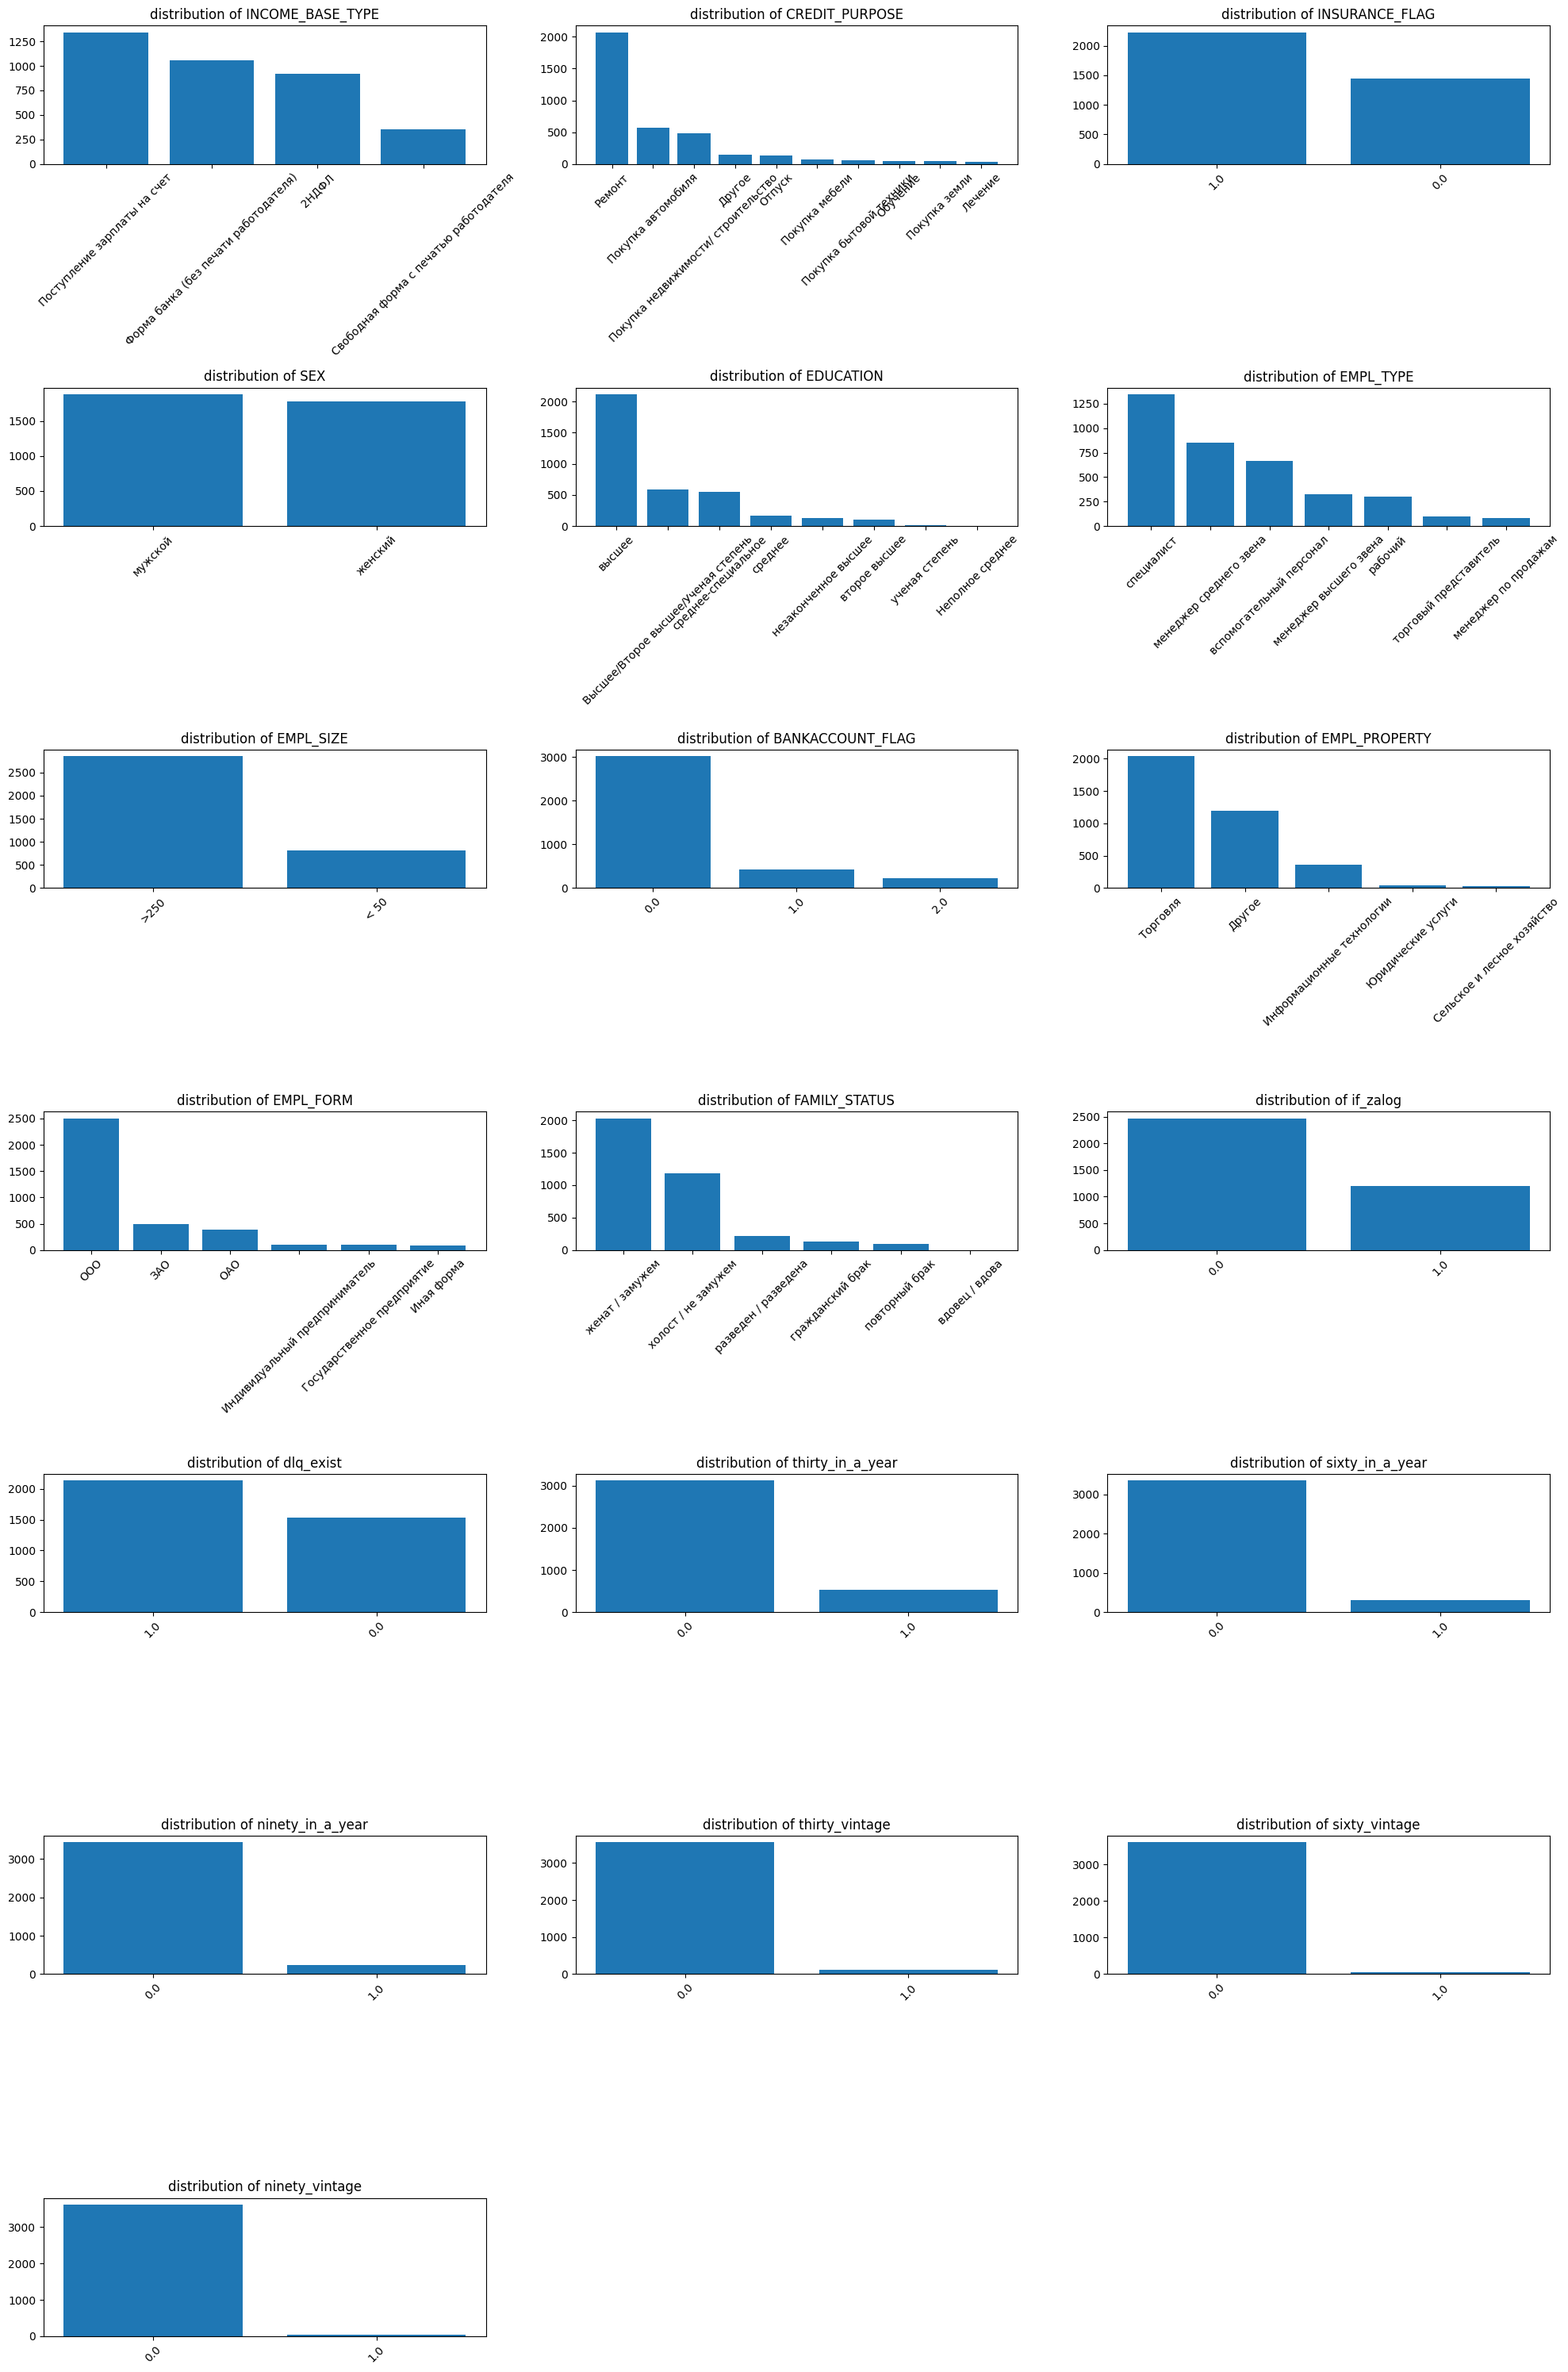

In [24]:
fig, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()
for i, col in enumerate(cathegorical_val):
    count = df[col].value_counts(dropna=False)
    axes[i].bar(count.index.astype(str), count.values)
    axes[i].set_title(f'distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(cathegorical_val), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Finally, we will convert cathegorical indicators into integers. Binary values will remain as they are. For other variables we will apply one hot enconding.

example:
* INCOME_BASE_TYPE:
    * Форма банка (без печати работодателя) : income_base_type_Форма банка (без печати работодателя)
    * Поступление зарплаты на счет : income_base_type_Поступление зарплаты на счет
    * 2НДФЛ : income_base_type_2НДФЛ
    * Свободная форма с печатью работодателя : income_base_type_Свободная форма с печатью работодателя

exception:
* EDUCATION:
    * one hot econding
        * среднее : has_secondary
        * высшее : has_higher
        * среднее-специальное : has_vocational
        * второе высшее : has_second_higher
        * незаконченное высшее : has_incomplete_higher
        * Неполное среднее : has_incomplete_secondary
        * ученая степень : has_phd

    * some cathegories overlap: 'Высшее/Второе высшее/Ученая степень' with 'высшее', 'второе высшее', 'ученая степень'. To deal with it, we will delete the value Высшее/Второе высшее/Ученая степень and set multiple falgs = 1. ex: if a client has PHD => has_higher = 1, has_second_higher = 1, has_phd = 1.


In [25]:
def clean_cathegory(val):
    if pd.isna(val): return val
    val = str(val).lower()
    val = re.sub(r'[ /-]+', '_', val)
    val = val.strip('_')
    return val

def one_hot_encode(df):
    df_new = df.copy()
    education_map = {
        'среднее': ['has_secondary'],
        'среднее-специальное': ['has_vocational'],
        'Неполное среднее': ['has_incomplete_secondary'],
        'незаконченное высшее': ['has_incomplete_higher'],
        'высшее': ['has_higher'],
        'второе высшее': ['has_second_higher'],
        'ученая степень': ['has_phd'],
        'Высшее/Второе высшее/Ученая степень': ['has_higher','has_second_higher','has_phd']
        }
    # fill with 0
    all_flags = sorted(set(sum(education_map.values(), [])))
    for flag in all_flags: df_new[flag] = 0

    # fill flags with 1
    for i, val in df_new['EDUCATION'].items():
        if val in education_map:
            for flag in education_map[val]: df_new.at[i, flag] = 1

    df_new = df_new.drop(columns=['EDUCATION'])
    df_new['SEX'] = df_new['SEX'].apply(lambda x : 1 if str(x) == 'мужской' else 0)
    df_new = df_new.drop(columns=['SEX'])

    cathegorical_val_one_hot = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'EMPL_TYPE',
                                 'EMPL_SIZE', 'BANKACCOUNT_FLAG', 'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS']

    for col in cathegorical_val_one_hot:
        df_new[col].apply(clean_cathegory)

    df_new = pd.get_dummies(df_new, columns=cathegorical_val_one_hot, prefix=[c.lower() for c in cathegorical_val_one_hot])
    return df_new

df_new = one_hot_encode(df)
df_new.head()

,ID,DTI,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,Period_at_work,age,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage,has_higher,has_incomplete_higher,has_incomplete_secondary,has_phd,has_second_higher,has_secondary,has_vocational,income_base_type_2НДФЛ,income_base_type_Поступление зарплаты на счет,income_base_type_Свободная форма с печатью работодателя,income_base_type_Форма банка (без печати работодателя),credit_purpose_Другое,credit_purpose_Лечение,credit_purpose_Обучение,credit_purpose_Отпуск,credit_purpose_Покупка автомобиля,credit_purpose_Покупка бытовой техники,credit_purpose_Покупка земли,credit_purpose_Покупка мебели,credit_purpose_Покупка недвижимости/ строительство,credit_purpose_Ремонт,insurance_flag_0.0,insurance_flag_1.0,empl_type_вспомогательный персонал,empl_type_менеджер высшего звена,empl_type_менеджер по продажам,empl_type_менеджер среднего звена,empl_type_рабочий,empl_type_специалист,empl_type_торговый представитель,empl_size_< 50,empl_size_>250,bankaccount_flag_0.0,bankaccount_flag_1.0,bankaccount_flag_2.0,empl_property_Другое,empl_property_Информационные технологии,empl_property_Сельское и лесное хозяйство,empl_property_Торговля,empl_property_Юридические услуги,empl_form_Государственное предприятие,empl_form_ЗАО,empl_form_Иная форма,empl_form_Индивидуальный предприниматель,empl_form_ОАО,empl_form_ООО,family_status_вдовец / вдова,family_status_гражданский брак,family_status_женат / замужем,family_status_повторный брак,family_status_разведен / разведена,family_status_холост / не замужем
0,1000008,0.40,3,0,88.0,40.0,1.0,1.0,1.0,0.0,0.0,0.023529,1.0,0.0,0.0,0.0,0.500000,3.0,3.0,83.0,6.0,1.0,1.0,7.0,64.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1000048,0.47,1,0,230.0,39.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.500000,1.0,1.0,37.0,2.0,0.0,1.0,3.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,1000068,0.42,0,0,39.0,26.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.666667,2.0,1.0,43.0,3.0,1.0,1.0,8.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
11,1000228,0.49,0,0,24.0,39.0,5.0,4.0,4.0,2.0,2.0,0.027027,0.0,0.0,0.0,0.0,0.800000,4.0,1.0,36.0,5.0,1.0,0.0,6.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True
15,1000308,0.58,0,0,33.0,57.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.444444,4.0,5.0,94.0,9.0,2.0,0.0,12.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True


In [26]:
data = []
for col in df_new.columns:
    data.append([col] + column_val(df_new[col]))

print(tabulate(data, headers=['column','unique','unique %', 'zeros','zeros %','empty','empty %'], tablefmt='orgtbl'))

| column                                                  |   unique |    unique % |   zeros |   zeros % |   empty |   empty % |
|---------------------------------------------------------+----------+-------------+---------+-----------+---------+-----------|
| ID                                                      |     3665 | 100         |       0 |  0        |       0 |         0 |
| DTI                                                     |       58 |   1.58254   |       0 |  0        |       0 |         0 |
| FULL_AGE_CHILD_NUMBER                                   |        6 |   0.163711  |    2198 | 59.9727   |       0 |         0 |
| DEPENDANT_NUMBER                                        |        3 |   0.0818554 |    3651 | 99.618    |       0 |         0 |
| Period_at_work                                          |      259 |   7.06685   |       0 |  0        |       0 |         0 |
| age                                                     |       39 |   1.06412   |       0 |  0

# segmentation: K-means

In order to decrease the variace of our data and to filter out the least informative variables, we will apply PCA method.

In [27]:

scaler = StandardScaler()
df_new_ = df_new.drop(columns='ID')
X_scaled = scaler.fit_transform(df_new_)

pca = PCA(n_components=0.7)
X_pca = pca.fit_transform(X_scaled)

results = []

for k in range(2, 18):
    kmeans = KMeans(n_clusters=k, max_iter=500, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    elbow = sum(np.min(cdist(X_pca, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_pca.shape[0]
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)

    cluster_sizes = np.bincount(labels)

    results.append({
        'k' : k,
        'elbow' : elbow,
        'silhouette' : sil,
        'davies_bouldin' : db
    })

results_df = pd.DataFrame(results)
results_df

,k,elbow,silhouette,davies_bouldin
0,2,7.125850,0.092256,3.668478
1,3,6.979128,0.089473,3.116622
2,4,6.852183,0.066787,2.974445
3,5,6.738992,0.067077,2.827003
4,6,6.639578,0.065169,2.840658
5,7,6.577710,0.069765,2.660288
6,8,6.503357,0.062830,2.687237
7,9,6.433523,0.045830,2.733055
8,10,6.370143,0.047320,2.670521
9,11,6.320406,0.058142,2.666357


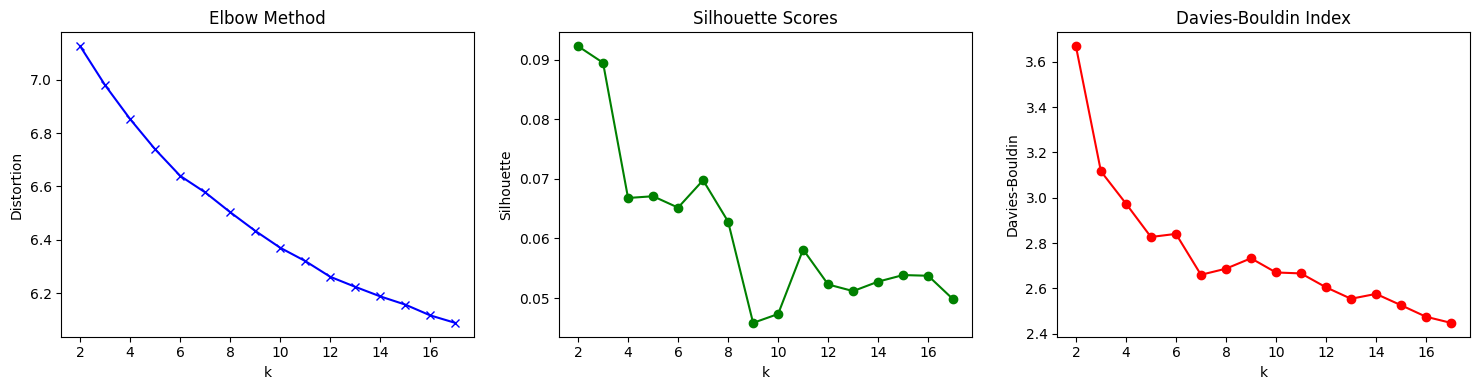

In [28]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(results_df['k'], results_df['elbow'], 'bx-')
plt.xlabel('k'); plt.ylabel('Distortion'); plt.title('Elbow Method')

plt.subplot(1,3,2)
plt.plot(results_df['k'], results_df['silhouette'], 'go-')
plt.xlabel('k'); plt.ylabel('Silhouette'); plt.title('Silhouette Scores')

plt.subplot(1,3,3)
plt.plot(results_df['k'], results_df['davies_bouldin'], 'ro-')
plt.xlabel('k'); plt.ylabel('Davies-Bouldin'); plt.title('Davies-Bouldin Index')

plt.tight_layout(); plt.show()


As we can see, the most promising numbers of clusters are: k = 9, 10, 11, 12
lets check clustering by plotting them

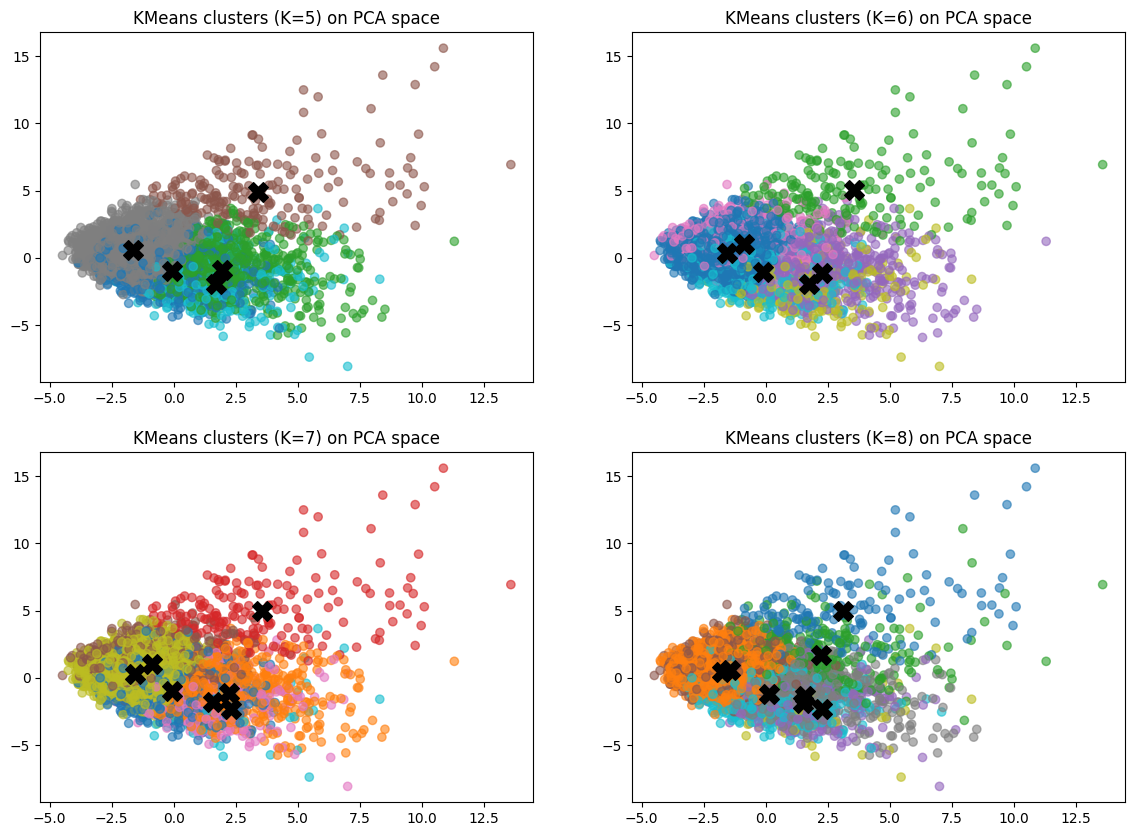

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, k in enumerate(range(5, 9)):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    ax = axes[idx//2, idx%2]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)

    centers = kmeans.cluster_centers_
    ax.scatter(centers[:,0], centers[:,1], c='black', s=200, marker='X')
    ax.set_title(f'KMeans clusters (K={k}) on PCA space')
plt.tight_layout
plt.show()

Visually, the best separation and homogeneity of clusters are in the kmeans with 5 clusters

In [30]:
kmeans = KMeans(n_clusters=5, n_init=50, random_state=42)
labels = kmeans.fit_predict(X_pca)

centers_pca = kmeans.cluster_centers_
centers_scaled = pca.inverse_transform(centers_pca)
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, columns=df_new_.columns, index=[f'cluster_{i+1}' for i in range(5)])
centers_df

,DTI,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,Period_at_work,age,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage,has_higher,has_incomplete_higher,has_incomplete_secondary,has_phd,has_second_higher,has_secondary,has_vocational,income_base_type_2НДФЛ,income_base_type_Поступление зарплаты на счет,income_base_type_Свободная форма с печатью работодателя,income_base_type_Форма банка (без печати работодателя),credit_purpose_Другое,credit_purpose_Лечение,credit_purpose_Обучение,credit_purpose_Отпуск,credit_purpose_Покупка автомобиля,credit_purpose_Покупка бытовой техники,credit_purpose_Покупка земли,credit_purpose_Покупка мебели,credit_purpose_Покупка недвижимости/ строительство,credit_purpose_Ремонт,insurance_flag_0.0,insurance_flag_1.0,empl_type_вспомогательный персонал,empl_type_менеджер высшего звена,empl_type_менеджер по продажам,empl_type_менеджер среднего звена,empl_type_рабочий,empl_type_специалист,empl_type_торговый представитель,empl_size_< 50,empl_size_>250,bankaccount_flag_0.0,bankaccount_flag_1.0,bankaccount_flag_2.0,empl_property_Другое,empl_property_Информационные технологии,empl_property_Сельское и лесное хозяйство,empl_property_Торговля,empl_property_Юридические услуги,empl_form_Государственное предприятие,empl_form_ЗАО,empl_form_Иная форма,empl_form_Индивидуальный предприниматель,empl_form_ОАО,empl_form_ООО,family_status_вдовец / вдова,family_status_гражданский брак,family_status_женат / замужем,family_status_повторный брак,family_status_разведен / разведена,family_status_холост / не замужем
cluster_1,0.346005,0.646320,0.012628,53.099223,37.727023,1.342304,0.890214,0.623938,0.448550,0.370674,0.044254,0.486967,0.265716,0.099761,0.065405,0.443465,2.108496,2.849322,84.833425,4.957818,0.992437,0.747892,15.924663,62.030651,0.578485,0.069352,0.016809,0.004363,0.014428,0.000176,0.001565,0.775524,0.027810,0.000177,0.201748,0.229372,0.062771,0.099351,0.144306,0.034111,0.223104,0.598478,0.037189,0.012272,0.009996,0.033008,0.142977,0.018069,0.015957,0.028548,0.123320,0.578663,0.408062,0.591938,0.129692,0.349961,0.017261,0.200140,0.048702,0.252167,0.002078,0.904610,0.095390,0.906948,0.063220,0.029831,0.284258,0.055786,0.003000,0.606936,0.050020,-0.006012,0.046358,0.041089,0.132474,-0.007984,0.794075,0.000323,0.010418,0.641293,0.021007,0.065139,0.261819
cluster_2,0.435075,0.634833,0.000430,72.198660,37.742747,2.015415,1.223461,0.784572,0.461412,0.328602,0.040045,0.463717,0.695607,0.320153,0.184236,0.377741,3.661076,6.616203,149.689055,10.277279,1.928725,1.279354,6.763224,79.654984,0.768115,0.145784,0.046933,0.027490,0.018310,0.000813,-0.005450,0.799730,0.019604,0.001884,0.281582,0.315647,0.017544,0.116405,0.248853,0.301097,0.062302,0.387749,0.041778,0.013662,0.014432,0.023876,0.080815,0.017036,0.012434,0.023367,0.130187,0.642413,0.396011,0.603989,0.138727,0.066815,0.032191,0.320383,0.064353,0.360498,0.017033,0.093925,0.906075,0.844572,0.103358,0.052069,0.367157,0.062402,0.016791,0.545999,0.007651,0.044877,0.154686,0.029569,0.018055,0.141059,0.611755,-0.000152,0.040031,0.605431,0.037767,0.055134,0.261790
cluster_3,0.412710,0.476874,0.014154,47.681152,34.804546,6.346737,5.330543,4.436889,3.523538,2.843631,0.037943,0.294478,0.907752,0.603868,0.420150,0.483108,2.701530,3.684822,73.544479,6.386352,1.456344,0.298485,8.932547,51.962366,0.437215,0.076696,0.019060,0.002931,0.025732,0.008256,-0.000244,0.764920,0.037027,-0.000391,0.102442,0.133781,0.029922,0.124664,0.652989,0.126990,0.103471,0.116550,0.020241,0.008618,0.023588,0.025383,0.122587,0.015566,0.009514,0.006028,0.175266,0.593210,0.315206,0.684794,0.168180,0.058717,0.032435,0.239112,0.069938,0.399343,0.032276,0.157513,0.842487,0.733462,0.110114,0.156425

we build a tree to interpret data, based on binary separations of our data. It's not a replacement for the data clustering, but more like an additional source of insights for it (in some sort, it also performs some kind of clustering). It will allow us to identify the most important separation features for our dataset.

We can notice the following clusters:


### cluster 1: Stable, low-risk borrowers, low activity
* work in a small company
* low number of delinquecies
* low number of current credits
* low number of recent applications for credits
* low number of active accounts


### cluster 2: active, experienced borrowers with moderate risk
* work in a large company
* work for a long time in a company
* moderate number of delinquecies
* high number of current credits
* moderate number of recent applications for credits

### cluster 3: credit seeking borrowers with emerging risk
* work in a large company
* short employment history
* high number of delinquencies
* high number of recent applications for credits
* high number of active accounts

### cluster 4: consevative, low risk borrowers with low credit need
* work in a large company
* low number of delinquencies
* low number of current credits
* low number of active accounts

### cluster 5: High risk borrowers with delinquency patterns
* work mostly in a large company
* high number of delinquecies
* high number of recent applications for credits
* high creadit activity
* high delay times

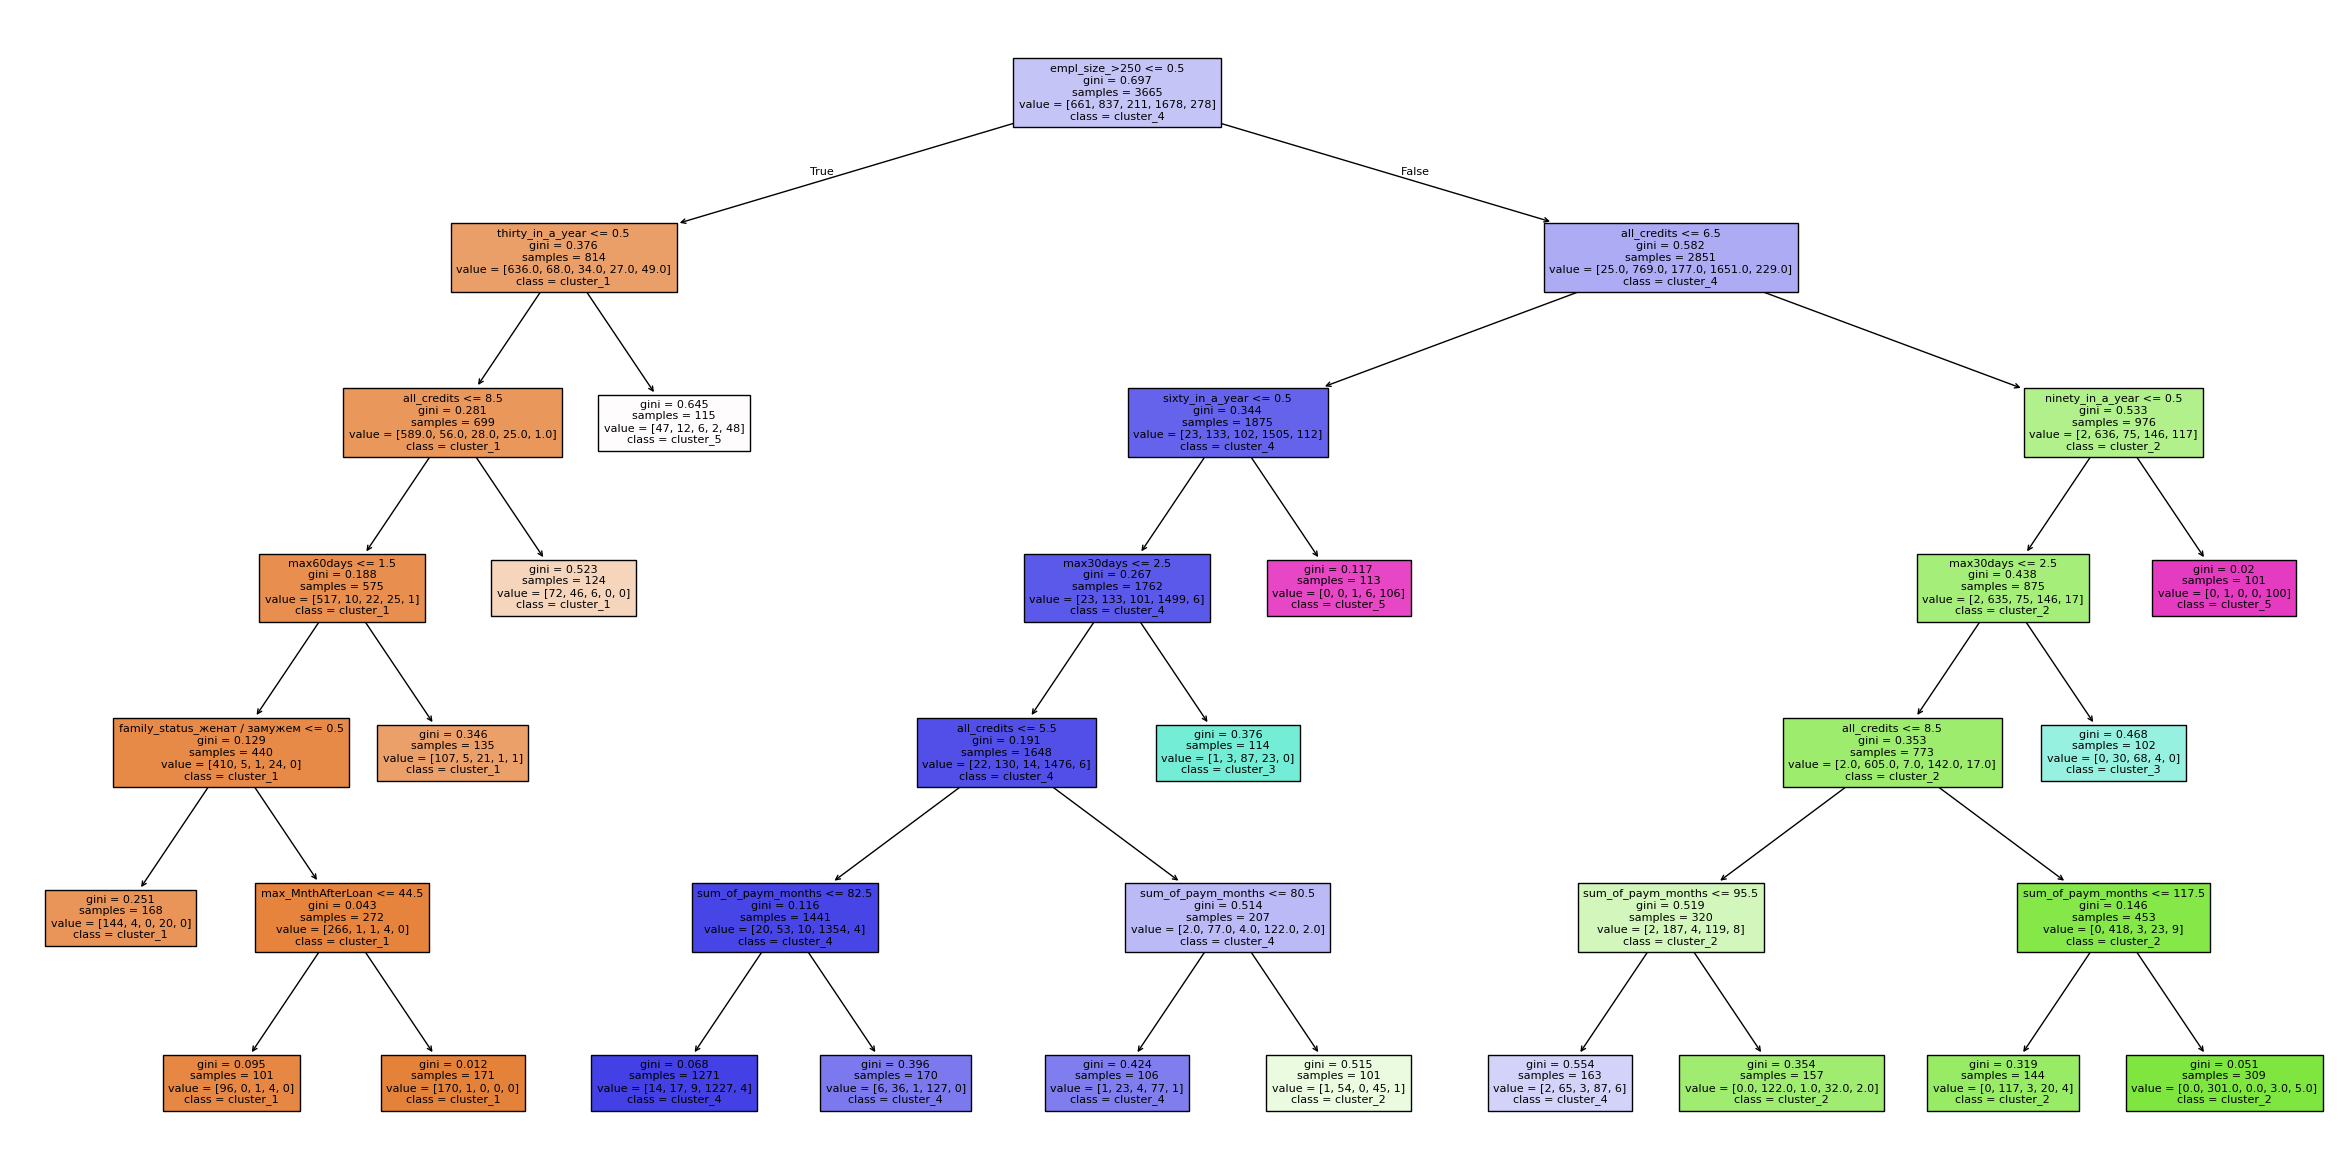

In [31]:
X_tree = df_new_.copy()
y_tree = labels
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=100, random_state=42)
tree.fit(X_tree, y_tree)

plt.figure(figsize=(30, 15))
plot_tree(tree, feature_names=X_tree.columns, class_names=[f'cluster_{i+1}' for i in range(5)], filled=True, fontsize=8)
plt.show()

# Segmentation: RMF

Our goal is to find out is the client is actually a good loaner
* Recency: min_MnthAfterLoan - how recently the client took a loan
* Monetary: sum_of_paym_months - total payment volume
* Frequency: all_credits - total number of credits


In [71]:
df_new['R_score'] = pd.qcut(df_new['min_MnthAfterLoan'], q=5, labels=[5,4,3,2,1])
df_new['M_score'] = pd.qcut(df_new['sum_of_paym_months'], q=5, labels=[1,2,3,4,5])
df_new['F_score'] = pd.qcut(df_new['all_credits'], q=5, labels=[1,2,3,4,5])

df_new['RMF_segment'] = (df_new['R_score'].astype(str) + df_new['M_score'].astype(str) + df_new['F_score'].astype(str))

In [89]:
def rmf_bin(row):
    R = int(row['R_score'])
    M = int(row['M_score'])
    F = int(row['F_score'])

    if (M == 5 and F == 5) or (M == 5 and R >= 4) or (F == 5 and R >= 4): return 'bin 5'
    if (M >= 4 and F >= 3) or (F == 5 and M >= 3): return 'bin 4'
    if (M in [3,4] and F in [3,4]): return 'bin 3'
    if (M == 3 and F <= 3 and R <= 4): return 'bin 2'
    return 'bin 1'


In [90]:
df_new['RMF_bin'] = df_new.apply(rmf_bin, axis=1)

In [91]:
mode_portrait = df_new.groupby('RMF_bin').agg(lambda x: x.mode().iloc[0])

In [94]:
categorical_vars = ['R_score', 'M_score', 'F_score', 'RMF_segment']
mode_portrait = df_new.groupby('RMF_bin')[categorical_vars].agg(lambda x: x.mode().iloc[0])
numeric_vars = ['DTI', 'max30days', 'max60days', 'max90days', 'thirty_in_a_year', 'sixty_in_a_year', 'ninety_in_a_year']
mean_portrait = df_new.groupby('RMF_bin')[numeric_vars].mean()

portrait = mode_portrait.copy()
portrait[numeric_vars] = mean_portrait[numeric_vars]
portrait

,R_score,M_score,F_score,RMF_segment,DTI,max30days,max60days,max90days,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year
RMF_bin,,,,,,,,,,,
bin 1,1,1,1,111,0.368687,0.788554,1.037952,1.402410,0.096988,0.057229,0.043373
bin 2,1,3,2,232,0.358901,0.549451,0.750916,1.010989,0.102564,0.062271,0.043956
bin 3,4,3,3,433,0.409748,0.876574,1.176322,1.727960,0.148615,0.093199,0.075567
bin 4,2,4,4,243,0.397175,0.829371,1.116084,1.606993,0.166434,0.103497,0.081119
bin 5,5,5,5,555,0.433371,1.133871,1.661290,2.625806,0.275806,0.135484,0.098387


## bin 1: low value, low activity, low risk RMF: 111
* low debt to income
* low recency
* low - number of recent applications for credits
* low payments

## bin 2: low-medium calue, stable clients RMF: 232
* lowest DTI
* low recency
* medium credit usage
* medium payments

## bin 3: medium value, active, moderate risk clients RMF: 433
* medium DTI
* recent
* medium credit usage
* medium payments

## bin 4: high monetary, high frequence, high risk RMF: 243
* low DTI
* medium - old recency
* high credit usage
* high payments

## bin 5: top monetary, top frequence, top risk RMF: 555
* highest DTI
* high recency
* top credit usage
* top payments